In [1]:
import os
import gradio as gr
from openai import OpenAI
import glob
from dotenv import load_dotenv

In [2]:
load_dotenv(override = True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [3]:
MODEL = 'gpt-4o-mini'
db_name = 'vector_db'

In [45]:
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import numpy as np
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [8]:
folders = glob.glob("knowledge-base/*")
text_loader_kwargs = {'encoding': 'utf-8'}

In [9]:
documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob = '**/*.md', loader_cls = TextLoader, loader_kwargs = text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata['doc_type'] = doc_type
        documents.append(doc)
        
    

In [10]:
len(documents)

31

In [12]:
textsplitter = CharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
chunks = textsplitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [14]:
chunks[6]

Document(metadata={'source': 'knowledge-base\\contracts\\Contract with Apex Reinsurance for Rellm.md', 'doc_type': 'contracts'}, page_content="1. **Technical Support**: Provider shall offer dedicated technical support to the Client via phone, email, and a ticketing system during business hours (Monday to Friday, 9 AM to 5 PM EST).\n\n2. **Training and Onboarding**: Provider will deliver comprehensive onboarding training for up to ten (10) members of the Client's staff to ensure effective use of the Rellm solution.\n\n3. **Updates and Maintenance**: Provider is responsible for providing updates to the Rellm platform to improve functionality and security, at no additional cost to the Client.\n\n4. **Escalation Protocol**: Issues that cannot be resolved at the first level of support will be escalated to the senior support team, ensuring that critical concerns are addressed promptly.\n\n---\n\n**Acceptance of Terms**: By signing below, both parties agree to the Terms, Renewal, Features, an

In [15]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found : {', '.join(doc_types)}")

Document types found : company, products, employees, contracts


In [16]:
for chunk in chunks:
    if 'CEO' in chunk.page_content:
        print(chunk)
        print('_________')

page_content='3. **Regular Updates:** Insurellm will offer ongoing updates and enhancements to the Homellm platform, including new features and security improvements.

4. **Feedback Implementation:** Insurellm will actively solicit feedback from GreenValley Insurance to ensure Homellm continues to meet their evolving needs.

---

**Signatures:**

_________________________________  
**[Name]**  
**Title**: CEO  
**Insurellm, Inc.**

_________________________________  
**[Name]**  
**Title**: COO  
**GreenValley Insurance, LLC**  

---

This agreement represents the complete understanding of both parties regarding the use of the Homellm product and supersedes any prior agreements or communications.' metadata={'source': 'knowledge-base\\contracts\\Contract with GreenValley Insurance for Homellm.md', 'doc_type': 'contracts'}
_________
page_content='## Support

1. **Customer Support**: Velocity Auto Solutions will have access to Insurellm’s customer support team via email or chatbot, availa

In [18]:
embeddings = OpenAIEmbeddings()

In [32]:
if os.path.exists(db_name):
    Chroma(persist_directory = db_name, embedding_function = embeddings).delete_collection()

In [33]:
vectorstore = Chroma.from_documents(persist_directory = db_name, embedding = embeddings, documents = chunks)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [35]:
collection = vectorstore._collection
sample_embeddings = collection.get(limit = 1, include = ['embeddings'])['embeddings'][0]
dimensions = len(sample_embeddings)
print(f"The vectors have {dimensions} dimensions")


The vectors have 1536 dimensions


In [42]:
result = collection.get(include = ['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

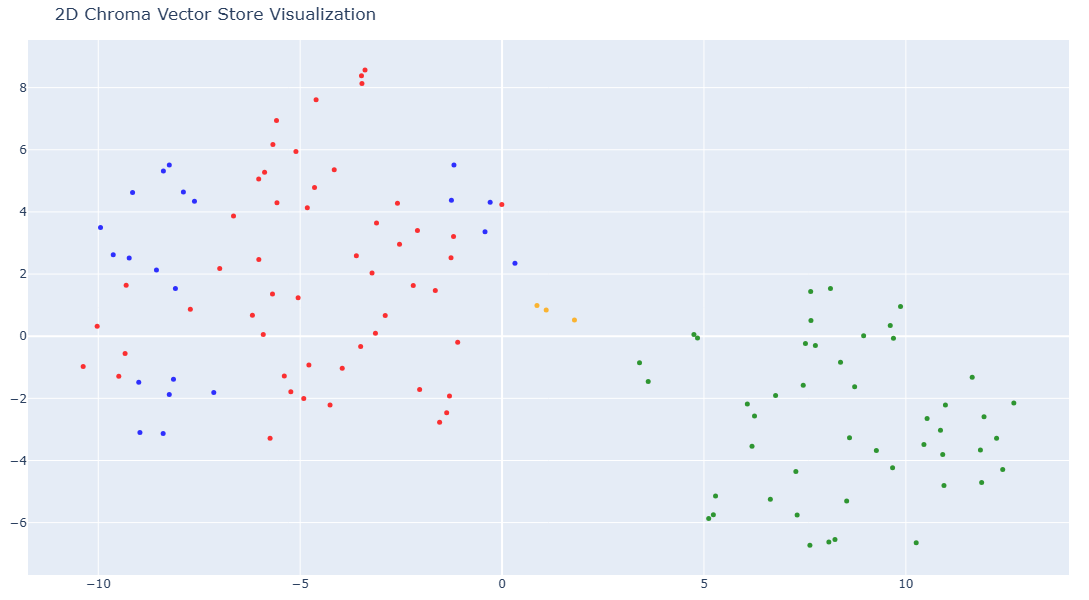

In [43]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

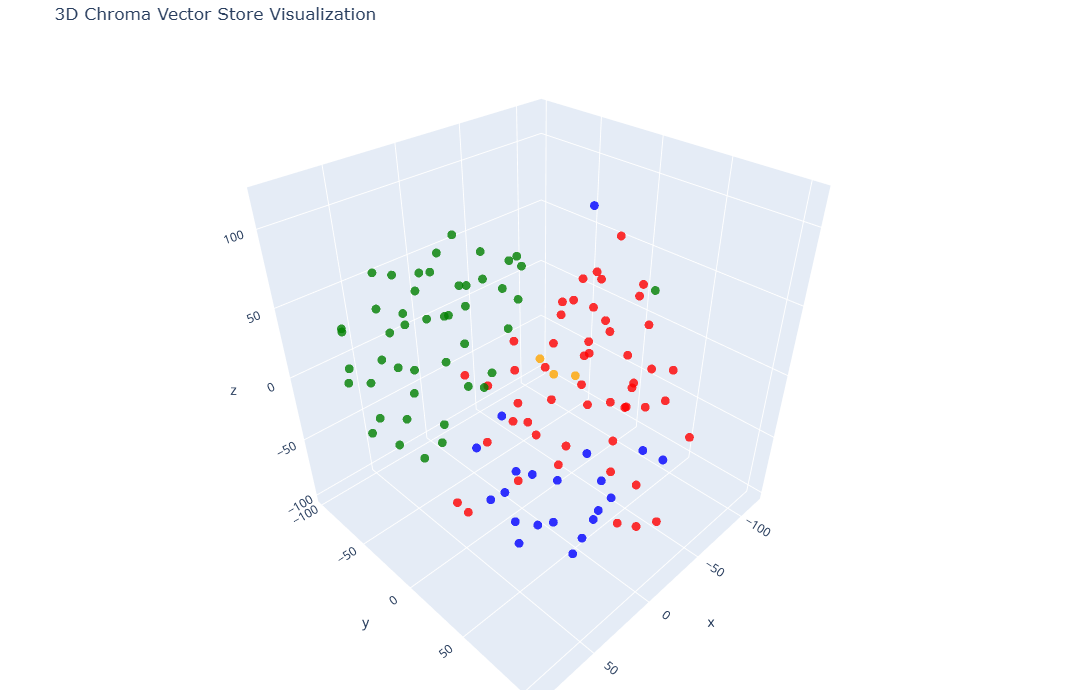

In [44]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [54]:
llm = ChatOpenAI(temperature = 0.7, model_name = MODEL)
memory = ConversationBufferMemory(memory_key = 'chat_history', return_messages = True)
retriever = vectorstore.as_retriever(search_kwargs = {'k' : 25})
conversation_chain = ConversationalRetrievalChain.from_llm(memory = memory, retriever = retriever, llm = llm)


In [55]:
def chat(message, history):
    result = conversation_chain.invoke({'question' : message})
    return result['answer']

In [56]:
view = gr.ChatInterface(chat, type = 'messages').launch(inbrowser = True)

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.
